# Recurrent Nerual Network for weather forecast

Some of interesting models, which are listed below, from the book, **Deep Learning with Python by Francois Chollet** were taken.

* Gated Recurrent Unit (GRU)
* GRU with dropouts 
* Stacking GRU layers

In [1]:
import os
import numpy as np

import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

### Data preparation

* Data: [jena_climate](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

* This step primarily contains following steps:
    1. Data parsing
    2. Normalization
    3. Data generation for modeling

### 1. Loading the downloaded data into numpy array

In [3]:
data_dir = '../data'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print("INFO: # of columns: {}".format(len(header)))
print("INFO: {}".format(", ".join(header)))

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    #print("Coding: ", float_data.shape, len(values))
    float_data[i, :len(values)] = values

print("INFO: array shape {}".format(float_data.shape))

INFO: # of columns: 15
INFO: "Date Time", "p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)", "VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)", "H2OC (mmol/mol)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)", "wd (deg)"
INFO: array shape (420552, 14)


### 2. Normalizing the data

In [4]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

### 3. Creating generator for fitting Keras model

In [5]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### Keras Models

1. Gated Recurrent Unit (GRU)
2. GRU with dropouts 
3. Stacking GRU layers

### 1. Gated Recurrent Unit (GRU)

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

gru_model = Sequential()
gru_model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
gru_model.add(layers.Dense(1))

gru_model.compile(optimizer=RMSprop(), loss='mse', metrics=['mse'])
gru_model.summary()
gru_loss_history_1 = gru_model.fit_generator(train_gen,
                                          steps_per_epoch=500,
                                          epochs=20,
                                          validation_data=val_gen,
                                          validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 132s 263ms/step - loss: 0.1540 - mean_squared_error: 0.1540 - val_loss: 0.1202 - val_mean_squared_error: 0.1202
Epoch 2/20
500/500 [==============================] - 114s 228ms/step - loss: 0.1304 - mean_squared_error: 0.1304 - val_loss: 0.1194 - val_mean_squared_error: 0.1194
Epoch 3/20
500/500 [==============================] - 113s 227ms/step - loss: 0.1253

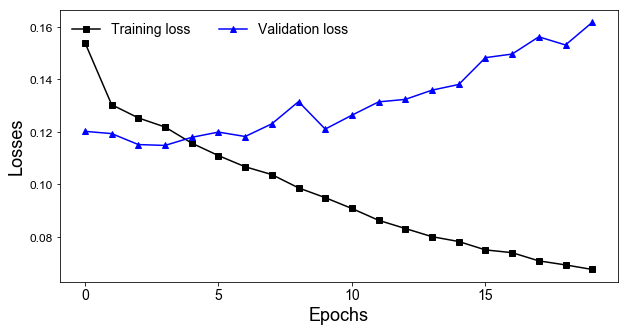

In [8]:
ts_tra_loss = gru_loss_history_1.history['loss']
ts_val_loss = gru_loss_history_1.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

plt.show()

### 2. GRU with dropouts 

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

gru_drop_model = Sequential()
gru_drop_model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
gru_drop_model.add(layers.Dense(1))

gru_drop_model.compile(optimizer=RMSprop(), loss='mse', metrics=['mse'])
gru_drop_model.summary()
gru_loss_history_2 = gru_drop_model.fit_generator(train_gen,
                                              steps_per_epoch=500,
                                              epochs=40,
                                              validation_data=val_gen,
                                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 119s 237ms/step - loss: 0.1857 - mean_squared_error: 0.1857 - val_loss: 0.1220 - val_mean_squared_error: 0.1220
Epoch 2/40
500/500 [==============================] - 118s 235ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1198 - val_mean_squared_error: 0.1198
Epoch 3/40
500/500 [==============================] - 120s 241ms/step - loss: 0.1544 - me

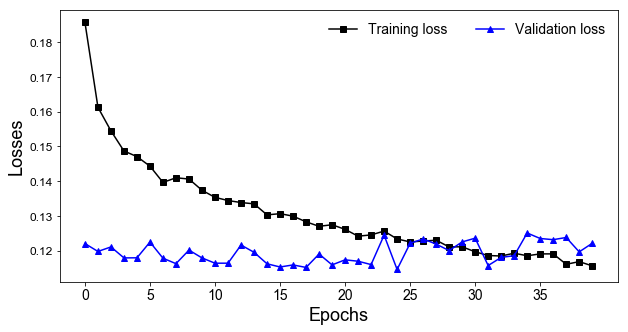

In [10]:
ts_tra_loss = gru_loss_history_2.history['loss']
ts_val_loss = gru_loss_history_2.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

plt.show()

### 3. Stacking GRU layers

In [11]:
# stacking recurrent layers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

stack_gru_drop_model = Sequential()
stack_gru_drop_model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
stack_gru_drop_model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
stack_gru_drop_model.add(layers.Dense(1))

stack_gru_drop_model.compile(optimizer=RMSprop(), loss='mse', metrics=['mse'])
gru_loss_history_3 = stack_gru_drop_model.fit_generator(train_gen,
                                                  steps_per_epoch=500,
                                                  epochs=40,
                                                  validation_data=val_gen,
                                                  validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 282s 563ms/step - loss: 0.1803 - mean_squared_error: 0.1803 - val_loss: 0.1293 - val_mean_squared_error: 0.1293
Epoch 2/40
500/500 [==============================] - 276s 552ms/step - loss: 0.1585 - mean_squared_error: 0.1585 - val_loss: 0.1206 - val_mean_squared_error: 0.1206
Epoch 3/40
500/500 [==============================] - 274s 549ms/step - loss: 0.1510 - mean_squared_error: 0.1510 - val_loss: 0.1197 - val_mean_squared_error: 0.1197
Epoch 4/40
500/500 [==============================] - 274s 548ms/step - loss: 0.1449 - mean_squared_error: 0.1449 - val_loss: 0.1174 - val_mean_squared_error: 0.1174
Epoch 5/40
500/500 [==============================] - 275s 550ms/step - loss: 0.1389 - mean_squared_error: 0.1389 - val_loss: 0.1174 - val_mean_squared_error: 0.1174
Epoch 6/40
500/500 [==============================] - 276s 552ms/step - loss: 0.1373 - mean_squared_error: 0.1373 - val_loss: 0.1143 - val_mean_squared_error: 0.1143
Epoc

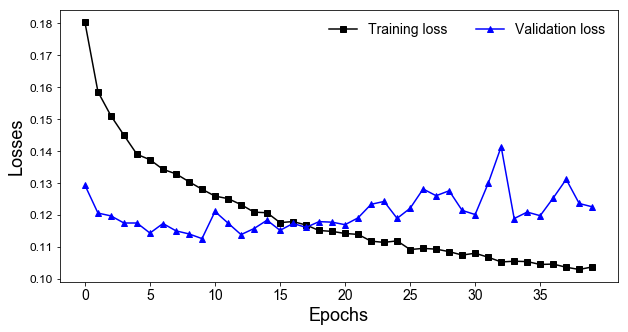

In [12]:
ts_tra_loss = gru_loss_history_3.history['loss']
ts_val_loss = gru_loss_history_3.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

plt.show()

In [19]:
fo_gru_model = gru_model.evaluate_generator(test_gen, test_steps)
print("INFO: GRU: %5.3f" %fo_gru_model[0])
fo_gru_model = gru_drop_model.evaluate_generator(test_gen, test_steps)
print("INFO: GRU with drop: %5.3f" %fo_gru_model[0])
fo_gru_model = stack_gru_drop_model.evaluate_generator(test_gen, test_steps)
print("INFO: Stack GRUs with drop: %5.3f" %fo_gru_model[0])

INFO: GRU: 0.178
INFO: GRU with drop: 0.127
INFO: Stack GRUs with drop: 0.134


### Can good fit model be generated?